# Recurrent_neural_networks

D'après [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python?a_aid=keras&a_bid=76564dff). 


On va observer une série météo contenant notamment la température, la pression, l'humidité. On va essayer de prédire la température future. 

On utilisera les Réseau de neurones récurents (RNN) qui sont spécifiques aux séries temporelles. 

## Settings

### load data

In [0]:
import os
if not os.path.exists("assets_neurone"):
    print("data creation")
    !git clone https://github.com/vincentvigon/assets_neurone
else:
    print("data updating")
    %cd assets_neurone
    !git pull https://github.com/vincentvigon/assets_neurone
    %cd ..

data creation
Cloning into 'assets_neurone'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 139 (delta 14), reused 29 (delta 9), pack-reused 103
Receiving objects: 100% (139/139), 24.19 MiB | 28.73 MiB/s, done.
Resolving deltas: 100% (48/48), done.


### Imports

In [0]:
%reset -f
%tensorflow_version 1.x

In [0]:
import os
import matplotlib.pyplot as plt
plt.style.use("default")
import numpy as np
np.set_printoptions(linewidth=5000,precision=2,suppress=True)

import IPython

## Réseaux ne neurone récurrents

Les réseaux de neurones récurents (RNN) analysent une suite: série temporelle, suite de mots ...

Ils sont composé d'unités particulières. Nous en veront 3: 

* Simple RNN
* LSTM
* GRU



### Simple RNN

C'est l'unité de base. Elle transforme une suite d'inputs $(x_t)$ en suite  d'ouputs $(h_t)$ comme ceci: 

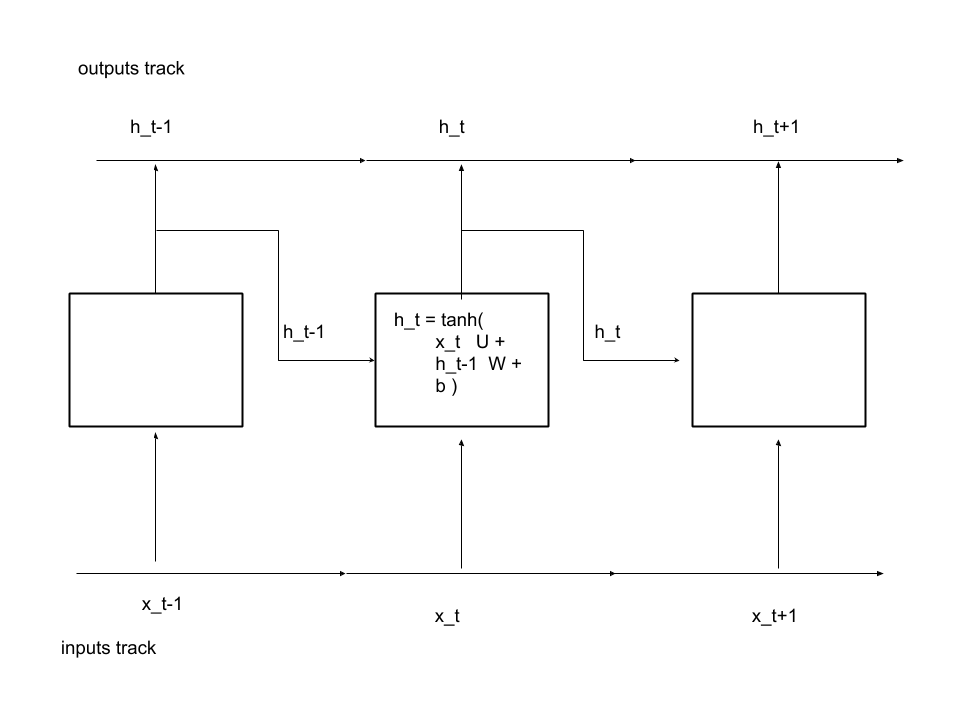

In [0]:
IPython.display.Image("assets_neurone/img/simple_rnn.png",width=800)

La formule est: 
$$
   h_t= \tanh( x_t U + h_{t-1} W + b )   
$$   

Notons que: 

* Le matrices de paramètres  $U,W,b$ ne dépendent pas de $t$. Elles décrivent la transition "générique" d'un temps à l'autre.  Elles sont initialisée aléatoirement, puis améliorées lors de la phase d'apprentissage. 
* A chaque temps la sortie $h_t$ est redirigée vers la cellule. 

Ainsi on peut  aussi avoir en tête le dessin suivant: 

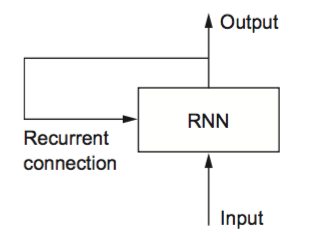

In [0]:
IPython.display.Image("assets_neurone/img/recurrent.png",width=300)

In [0]:
""" une implantation numpy d'un simple RNN """
def simpleRNN(inputs,dim_out):
    
    timesteps,dim_in=inputs.shape
    
    
    """les paramètres sont initialisés avec de petites valeur aléatoires."""
    U=0.1*np.random.random(size=[dim_out,dim_in])
    W=0.1*np.random.random(size=[dim_out,dim_out])
    b=0.1*np.random.random(size=[dim_out])
    
    outputs=np.zeros([timesteps,dim_out])
    last_out=np.zeros([dim_out]) 
    
    for t,input_t in enumerate(inputs):
        outputs[t,:]= np.tanh( U@input_t + W@last_out + b)
        last_out=outputs[t,:]
        
    return outputs

In [0]:
"""testons"""
inputs=np.array([[1,2],[1,3],[1,4],[0,5]])
outputs=simpleRNN(inputs,3)

print("inputs:")
print(inputs)
print("outputs:")
print(outputs)

inputs:
[[1 2]
 [1 3]
 [1 4]
 [0 5]]
outputs:
[[0.24 0.12 0.19]
 [0.32 0.14 0.24]
 [0.38 0.15 0.26]
 [0.37 0.11 0.21]]


 Observez la signature du constructeur de  `SimpleRNN` de keras, faites:
 
        import keras.layers
        keras.layers.SimpleRNN?

Parmis tous les arguments, il faut comprendre ceux-ci: 

* units: c'est `dim_out`
* activation='tanh'
* use_bias=True
* kernel_initializer='glorot_uniform': c'est la technique pour initialiser les paramètres `U` et `W`. Il s'agit de v.a uniforme sur un intervalle $[-l,+l]$ avec  
$$ 
l=\sqrt{\frac 6 {\mathtt{fan\_in} + \mathtt{fan\_out}}}
$$
avec $\mathtt{fan\_in}, \mathtt{fan\_out}$ le nombre de ligne et de colonne de la matrice. 
* return_sequences=False: le layer renvoie uniquement le tout dernier output: `outputs[-1,:]`. Dans notre implantation `numpy`, nous avons coder l'option `return_sequences=True`. 

### LSTM

D'après [ceci](https://isaacchanghau.github.io/post/lstm-gru-formula/) corrigé avec wikipedia. 


* LSTM (1997) = Long short time memory 
* GRU (2014) = Gatted recurrent unit

Ce sont des unités (=boites de neurone) conçues pour apprendre des informations contenue dans de longues séries temporelles (ex: des romans). Si l'on essayait de faire cela avec des empilement d'unité classiques (des couches denses), l'information se perdrait au fil des couches lors de la rétropopagation du gradient  (vanishing gradient problem).


L'idée est de rajouter une piste $(C_t)$ qui transporte (carry) l'information sur le long terme. Cette piste nourrit les neurones à chaque temps, mais elle est aussi modifiée à chaque temps.




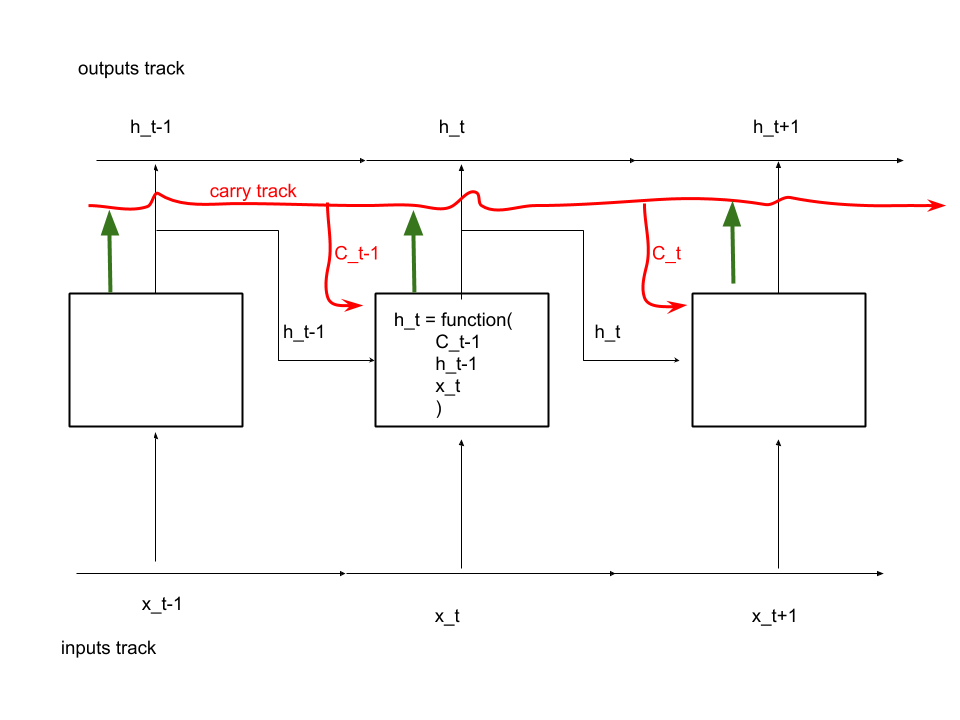

In [0]:
IPython.display.Image("assets_neurone/img/simple_rnn_carry.png",width=800)

Mais voici le schéma complet:

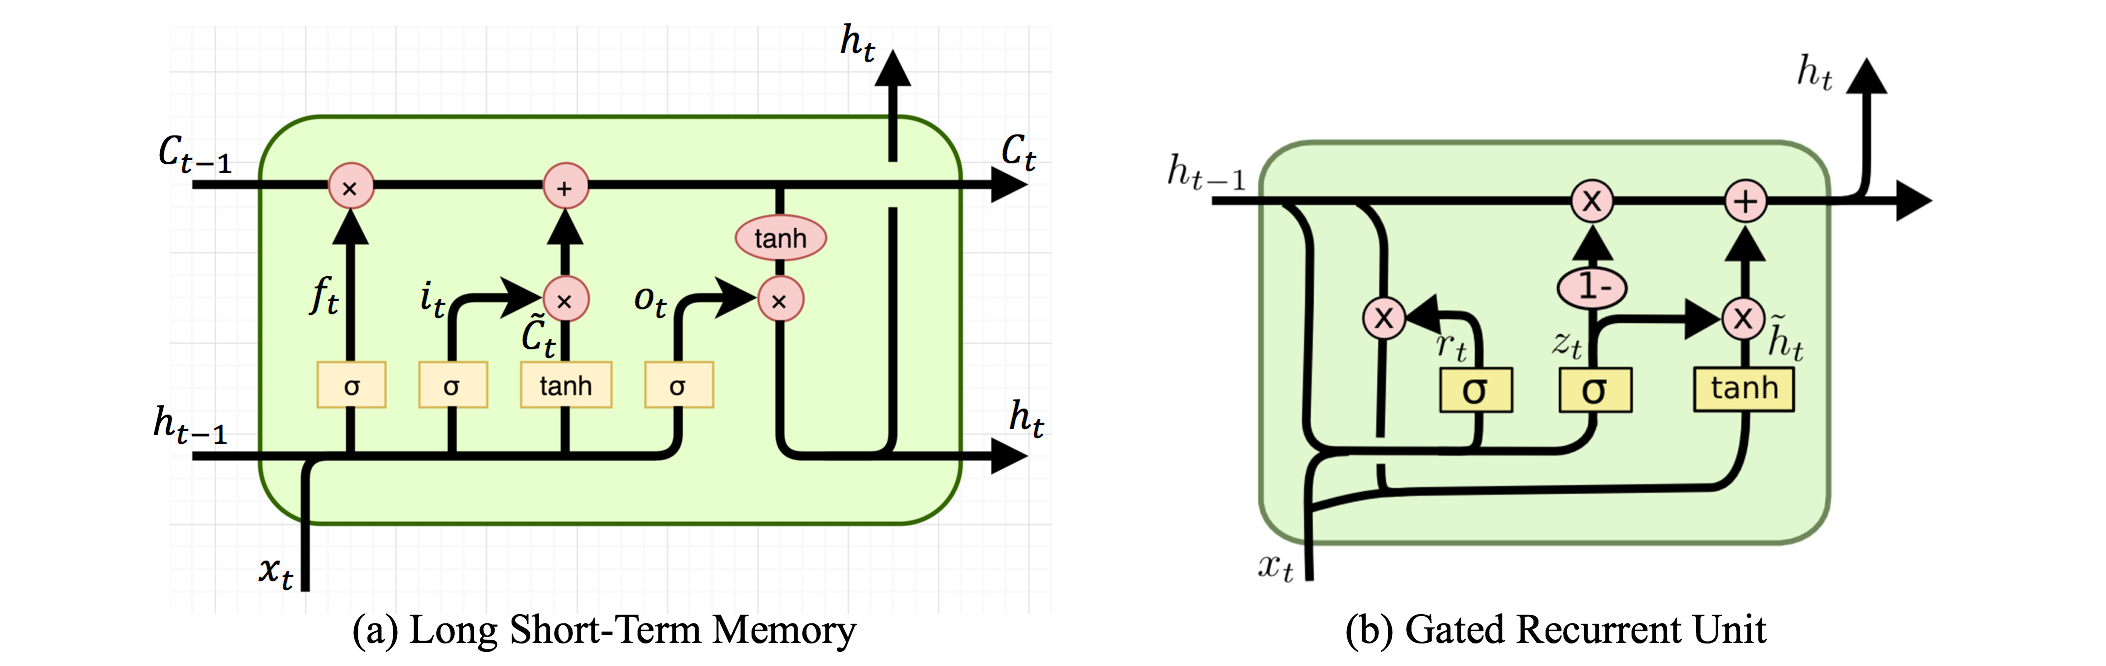

In [0]:
IPython.display.Image("assets_neurone/img/LSTM_GRU.png",width=800)

Considérons:

* $x_t$ l'entrée 
* $h_{t-1}$ la sortie de l'instant précédent.  
* $C_{t-1}$ le "Carry" précédent. 

On calcule les nouvelles quantités $h_t,C_t$ par:

\begin{align*}
i_t &= \sigma(x_t U^i + h_{t-1} W^i +b^i)   \qquad \text{input gate} \\
f_t &= \sigma(x_t U^f + h_{t-1} W^f +b^f)   \qquad \text{forget gate} \\
o_t &= \sigma(x_t U^o + h_{t-1} W^o +b^o)   \qquad \text{output gate} \\
\\
\tilde C_t &=\tanh(x_t U+ h_{t-1}W + b )   \qquad \text{additinal carry}  \\
C_t&= f_t * C_{t-1} + i_t*\tilde C_t  \qquad \text{updated carry} \\
\\
h_t&= o_t  * \tanh^?(C_t)   \qquad \text{output}  
\end{align*}

Toutes les matrices $U^*,W^*$ ne dépendent pas de $t$. Elles sont initialisées aléatoirement, puis améliorer par l'apprentissage.  

Les "gate" sont à valeur dans $[0,1]$. Elles sont mutlitpliées à d'autre quantités pour les laisser passer ou les anuler. 


***A vous:*** $(2\heartsuit)$ Quelles valeurs doivent prendre les différentes "gates" pour que l'on retombe sur un `simpleRNN`? Aide: la fonction $\tanh^?$ est soit la fonction $\tanh^?$, soit la fonction identité.   

### GRU

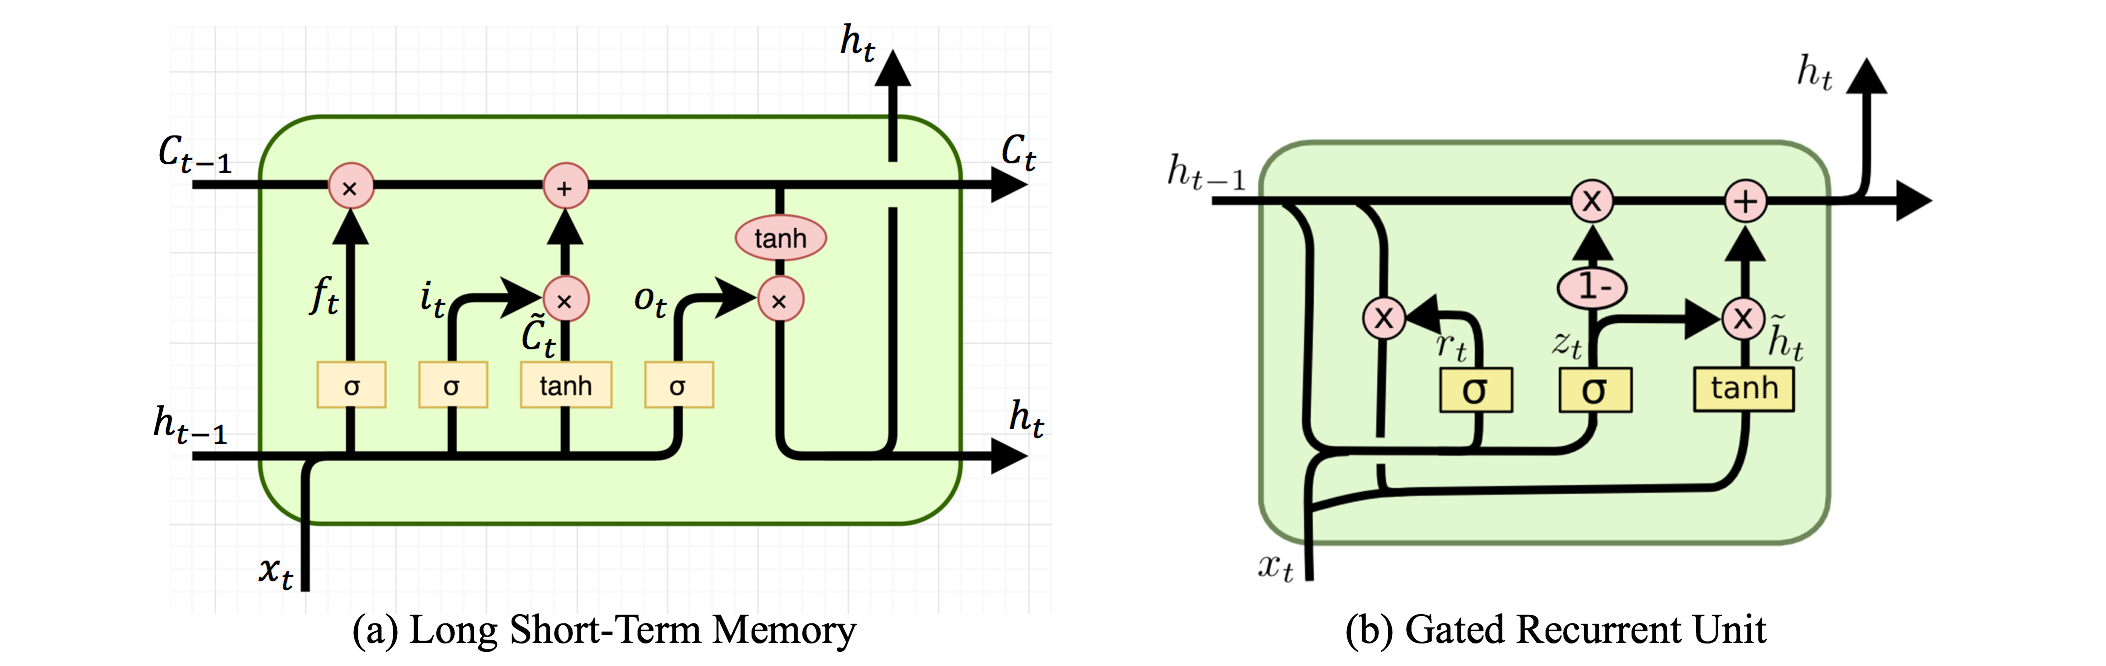

In [0]:
IPython.display.Image("assets_neurone/img/LSTM_GRU.png",width=800)

Considérons:

* $x_t$ l'entrée 
* $h_{t-1}$ la sortie de l'instant précédent.  

On calcule la nouvelle sortie $h_t$ par:
\begin{align*}
z_t &= \sigma(x_t U^z + h_{t-1} W^z +b^z)   \qquad \text{update gate} \\
r_t &= \sigma(x_t U^r + h_{t-1} W^r +b^r)   \qquad \text{reset gate} \\
\\
\tilde h_t &= \tanh(x_t U^h + r_t * h_{t-1} W^h + b ) \\
h_t &=(1-z_t)*h_{t-1} +z_t \tilde h_t 
\end{align*}

Toutes les matrices $U^*,W^*$ ne dépendent pas de $t$. Elles sont initialisées aléatoirement, puis améliorées par l'apprentissage.  



***A vous:*** $(2\heartsuit)$ Quelles valeurs doivent prendre les différentes "gates" pour que l'on retombe sur les `simpleRNN`?


## Données météo

Les données viennent du: Max-Planck-Institute for Biogeochemistry in Jena, Germany: http://www.bgc-jena.mpg.de/wetter/.

Il s'agit d'une unique série temporelle courant sur plusieurs années. 

### Un premier regard

In [0]:
""" lecture du fichier csv ligne à ligne. 
Alternative: utiliser np.loadtxt() """
f = open('assets_neurone/data/jena_climate_2009_2016.csv')
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


On convertit ces 420,551 lignes en un tableau numpy:

In [0]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [0]:
float_data[:10]

array([[ 996.52,   -8.02,  265.4 ,   -8.9 ,   93.3 ,    3.33,    3.11,    0.22,    1.94,    3.12, 1307.75,    1.03,    1.75,  152.3 ],
       [ 996.57,   -8.41,  265.01,   -9.28,   93.4 ,    3.23,    3.02,    0.21,    1.89,    3.03, 1309.8 ,    0.72,    1.5 ,  136.1 ],
       [ 996.53,   -8.51,  264.91,   -9.31,   93.9 ,    3.21,    3.01,    0.2 ,    1.88,    3.02, 1310.24,    0.19,    0.63,  171.6 ],
       [ 996.51,   -8.31,  265.12,   -9.07,   94.2 ,    3.26,    3.07,    0.19,    1.92,    3.08, 1309.19,    0.34,    0.5 ,  198.  ],
       [ 996.51,   -8.27,  265.15,   -9.04,   94.1 ,    3.27,    3.08,    0.19,    1.92,    3.09, 1309.  ,    0.32,    0.63,  214.3 ],
       [ 996.5 ,   -8.05,  265.38,   -8.78,   94.4 ,    3.33,    3.14,    0.19,    1.96,    3.15, 1307.86,    0.21,    0.63,  192.7 ],
       [ 996.5 ,   -7.62,  265.81,   -8.3 ,   94.8 ,    3.44,    3.26,    0.18,    2.04,    3.27, 1305.68,    0.18,    0.63,  166.5 ],
       [ 996.5 ,   -7.62,  265.81,   -8.36,   94.4 ,   

Traçons la température le long du temps. 

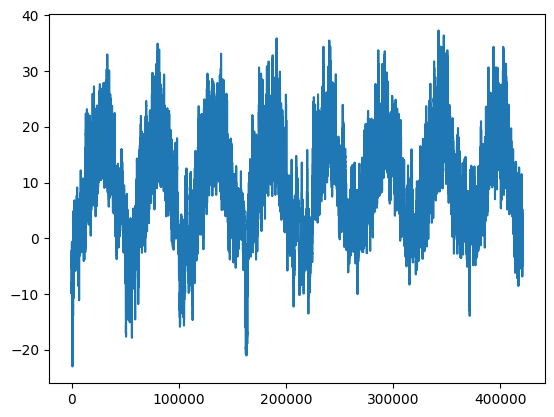

In [0]:
plt.plot(float_data[:, 1]);

***A vous:*** Sur combien d'année courre l'enregistrement? De combien de minutes les graduation sont espacée. 

In [0]:
nb_minutes=8*365*24*60

In [0]:
nb_minutes/len(float_data)

9.998311738647631

In [0]:
two_weeks=2*7*26*6
two_weeks

2184


Zoumons. 


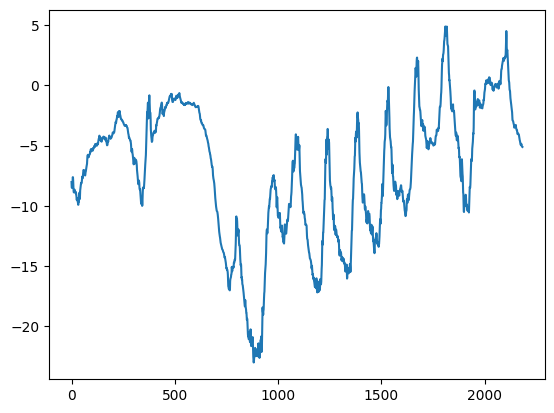

In [0]:
plt.plot(range(two_weeks), float_data[:two_weeks,1]);

***A vous:*** 

* $(1\heartsuit)$ A quoi corresponde les oscillations ci-dessus ? 

* $(1\heartsuit)$ Est-ce une températeur estivale?




Si on essayer de prédire la température moyenne d'un mois sur l'autre, le problème serait facile. Mais nous allons essayer de prédire la températeur d'un jour sur l'autre. 


### sous-échantilllonage

In [0]:
float_data.shape

(420551, 14)

On ne garde qu'un seul enregistrement par heure. Et on supprime l'index temporel. 

In [0]:
kernel=np.ones([6,1])/6
kernel

array([[0.17],
       [0.17],
       [0.17],
       [0.17],
       [0.17],
       [0.17]])

In [0]:
import scipy.signal 
smooth=scipy.signal.convolve(float_data[:,1:],kernel,mode="valid")
sub_sampled=smooth[::6,:]
sub_sampled.shape

(70091, 13)

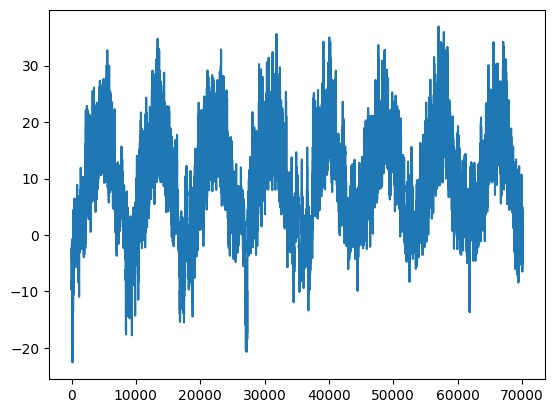

In [0]:
plt.plot(sub_sampled[:,0]);

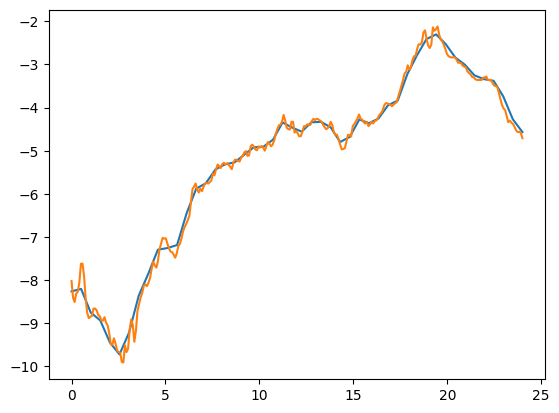

In [0]:
nb_days=2
plt.plot(np.linspace(0,24,24*nb_days),sub_sampled[:24*nb_days,0]);
plt.plot(np.linspace(0,24,24*nb_days*6),float_data[:24*nb_days*6,1]);

### Separation train/validation/test et normalisation

In [0]:
len_data=len(sub_sampled)
len_train=int(len_data*0.9)
len_val=int(len_data*0.05)
len_test=len_data-len_train-len_val

data_train=sub_sampled[:len_train]
data_val=sub_sampled[len_train:len_train+len_val]
data_test=sub_sampled[len_train+len_val:]


means = np.mean(data_train,axis=0)
stds = np.std(data_train,axis=0)

"""on retient deux constantes pour la suite:"""
MEAN=means[0]
STD=stds[0]
print("MEAN temperature",means[0])
print("STD:temperature",stds[0])



MEAN temperature 9.183297215749237
STD:temperature 8.436372928284651


On  a mis les  constantes `MEAN` et `STD` en majuscule pour les marquer comme des variables 'globales'  (= à retenir pour la suite) 

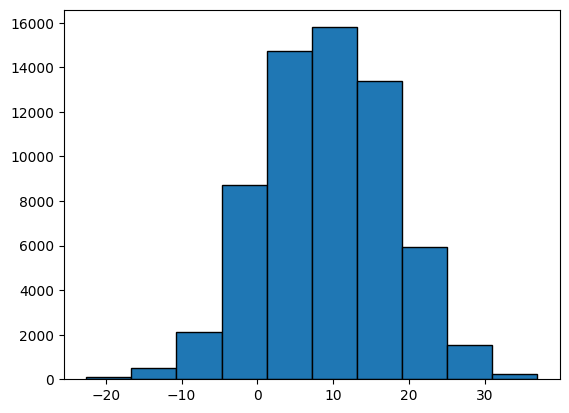

In [0]:
plt.hist(data_train[:,0],edgecolor="k");

In [0]:
def normalize(data):
    data_nor=data.copy()
    data_nor-=means
    data_nor/=stds
    
    return data_nor
 
data_train_nor=normalize(data_train)
data_val_nor=normalize(data_val)
data_test_nor=normalize(data_test)

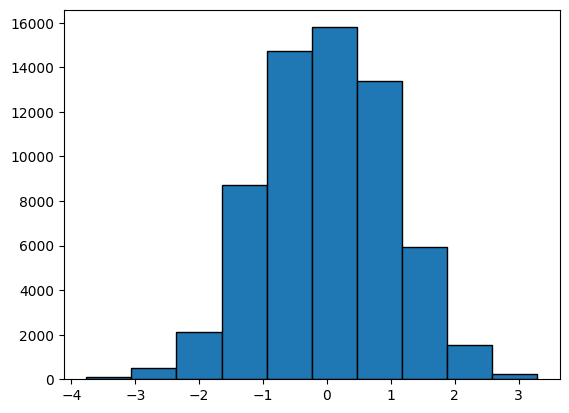

In [0]:
plt.hist(data_train_nor[:,0],edgecolor="k");

### Création des Batch

On va séparer la série temporelle en plusieurs paquets (batch) qui nouriront l'apprentissage. 

Notre but est de prédire la température à l'avance. Par exemple, en observant 48 heures, de données météo, on aimerait prédire la température 4 heures à l'avance. 

In [0]:
lookback = 48 # nb hours we observe
delay =    4 # delay to predict the temperature

In [0]:
#première technique: intervalle temporels aléatoires
def random_generator(data,batch_size=128):
    
    while True:
    
        samples=np.empty([batch_size,lookback,13])
        targets=np.empty([batch_size])


        for i in range(batch_size):
            t=np.random.randint(len(data)-delay-lookback)
            samples[i,:,:]=data[t:t+lookback,:]
            targets[i]=data[t+lookback+delay,0]

        yield samples,targets


In [0]:
train_generator=random_generator(data_train_nor)

In [0]:
x_train,y_train=next(train_generator)

x_train.shape,y_train.shape

((128, 48, 13), (128,))

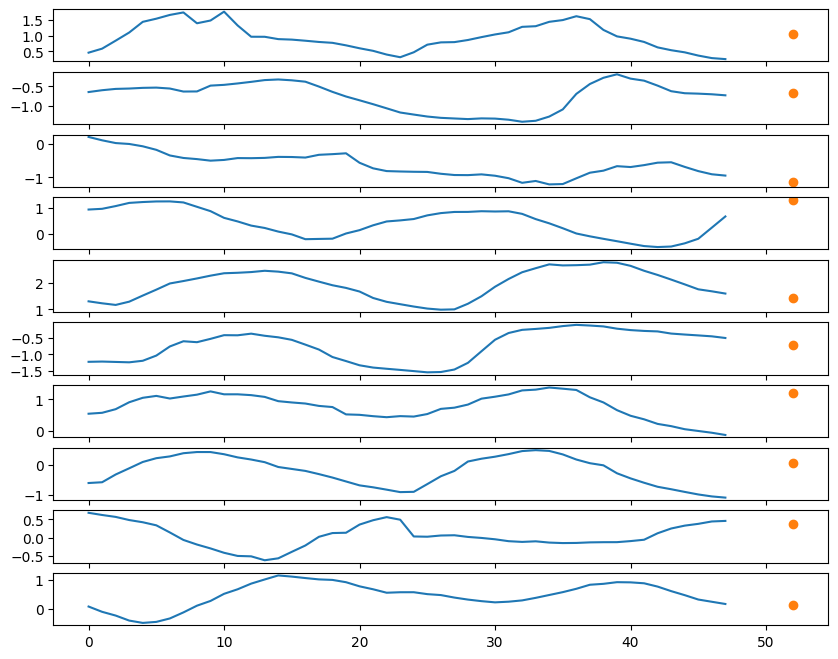

In [0]:
def plot_some(samples,targets,skip=1):
    nb=10
    fig,axs=plt.subplots(nb,1,figsize=(nb,8),sharex=True)

    for i in range(nb):
        axs[i].plot(samples[i*skip,:,1])
        axs[i].plot(samples.shape[1]+delay,targets[i*skip],"o")

plot_some(x_train,y_train)


In [0]:
#seconde technique: intervalles temporels disjoints. 
def sequential_data(data):
    
    nb=len(data)-delay-lookback
    samples=np.empty([nb,lookback,13])
    targets=np.empty([nb])
    
    for t in range(nb):
        samples[t,:,:]=data[t:t+lookback,:]
        targets[t]=data[t+lookback+delay,0]
        
    return samples,targets
        

In [0]:
x_val,y_val=sequential_data(data_val_nor)
x_test,y_tes=sequential_data(data_test_nor)

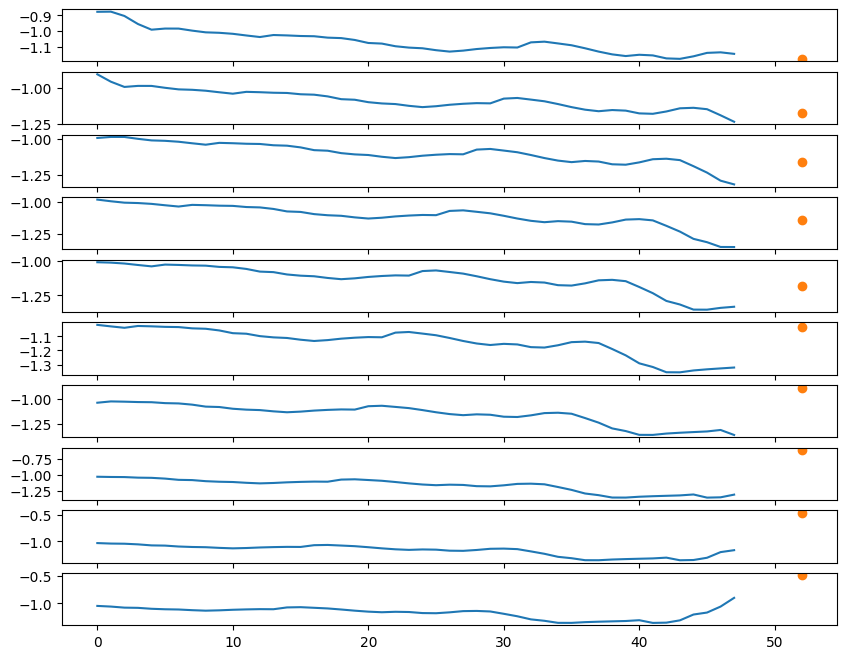

In [0]:
plot_some(x_val,y_val,skip=2)


### Une estimation de bon sens

On suppose que la courbe de températeur est relativement continue. Ainsi on peut bêtement prédire la températeur dans `delay` heure en donnant la tepérature de maintenant. 

* Si `delay=1` cela donnera une bonne prédiction
* Si `delay=12` cela donnera une plus mauvaise prédiction
* Si `delay=24` cela redonne un bonne prédiction. 

De manière générale, il faut toujours se trouver une manière triviale de prédire les données, cela permet de servir de référence. Parfois l'estimation triviale est très difficile à dépasser. 


In [0]:
naive_preds=x_val[:,-1,0]
naive_mae=np.mean(np.abs(naive_preds-y_val))
naive_mae

0.3822571470534667

Et si on remet cette erreur en degré (Celcius ou Kelvin ?):

In [0]:
naive_mae*STD

3.2248638470451914

## Modèles

### Fonctions paramètrant les apprentissage


On va se fixer un protocole pour évaluer tous nos modèles. 


In [0]:
"""
la fonction fit_generator requiert "générateur de donnée" qui envoie des batchs sans s'arrêter. 
"""
def train_model(model,loss,val_loss):
    
    history = model.fit_generator(train_generator,
                                      steps_per_epoch=100, #nombre d'appel du générateur par epoch
                                      epochs=50,          #à la fin de chaque époch: on fait une validation
                                      validation_data=(x_val,y_val)
                                 )
    
    loss.extend(history.history['loss'])
    val_loss.extend(history.history['val_loss'])


* En mode "développement", mettez des constantes pour que les apprentissage aille vite: exemple: quelques époques, et une centaine de pas par époque. Par exemple:
 * steps_per_epoch=50
 * epochs=10

* En mode "production", mettez des constantes pour que les apprentissages soit long et bon. Laissez tourner une nuit. Par exemple:
 * steps_per_epoch=500
 * epochs=40


In [0]:
""" Attention: adaptez ylim au problème"""
def plot_history(loss,val_loss):
    
    epochs = range(len(loss))
    
    fig,ax=plt.subplots()

    ax.plot(epochs, loss, 'bo', label='Training loss')
    ax.plot(epochs, val_loss, 'b', label='Validation loss')
    ax.plot([epochs[0],epochs[-1]],[naive_mae,naive_mae],label="naive loss")
    ax.set_ylim(0.1,0.65)
    ax.legend()

In [0]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


### Modèle dense


On applati toutes nos données: ainsi le nombre de variable est `lookback`*13. On ne prend pas du tout en compte la dimension temporelle des données. 

Il est important d'utiliser des modèles simplistes, pour voir si cela vaut le coup d'investir dans des modèles plus complexes, plus long à entrainer tel que les RNN. 


In [0]:
model_dense = Sequential()
model_dense.add(layers.Flatten(input_shape=( x_val.shape[1],13)))
model_dense.add(layers.Dense(32, activation='relu'))
model_dense.add(layers.Dense(1))

model_dense.compile(optimizer=RMSprop(), loss='mae')

loss_dense=[]
val_loss_dense=[]

In [0]:
train_model(model_dense,loss_dense,val_loss_dense)




Epoch 1/50





100/100 [==============================] - 10s 97ms/step - loss: 0.6652 - val_loss: 0.5987
Epoch 2/50
100/100 [==============================] - 1s 5ms/step - loss: 0.4800 - val_loss: 0.5300
Epoch 3/50
100/100 [==============================] - 1s 5ms/step - loss: 0.4036 - val_loss: 0.4387
Epoch 4/50
100/100 [==============================] - 1s 5ms/step - loss: 0.3445 - val_loss: 0.3097
Epoch 5/50
100/100 [==============================] - 1s 5ms/step - loss: 0.3102 - val_loss: 0.3430
Epoch 6/50
100/100 [==============================] - 1s 5ms/step - loss: 0.2863 - val_loss: 0.3099
Epoch 7/50
100/100 [==============================] - 1s 5ms/step - loss: 0.2675 - val_loss: 0.2944
Epoch 8/50
100/100 [==============================] - 1s 6ms/step - loss: 0.2507 - val_loss: 0.1922
Epoch 9/50
100/100 [==============================] - 1s 6ms/step - loss: 0.2308 - val_loss: 0.2376
Epoch 10/50
100/100 [==============================] - 1s 5ms/step - loss: 0.2280 - val_lo

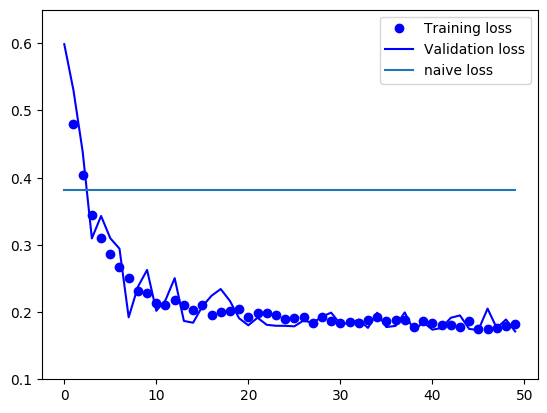

In [0]:
plot_history(loss_dense,val_loss_dense)

Si vous faites des prévisions sur 24 heures, votre modèles dense fera moins bien que la prédiction triviale. 

Cela peut paraitre étonnant car l'ensemble de tous les modèles denses inclus la prédiction triviale (il suffit de mettre toutes les flèches à zéro, sauf la flèche qui part de la variable "dernière température" ).

Mais l'ensemble de tous les modèles denses est un très gros ensemble, et il est très difficile pour l'algorithme d'optimisation de trouver exactement un jeu de paramètre donné. Ainsi notre bon sens n'est pas toujours dépassé par les réseaux de neurones artificiels.  


***A vous:*** $(1\heartsuit)$ Qu'est-ce qui se passe si on relance la fonction `train_model()` puis `plot_history()`? (On voit ici l'un la souplesse des notesbooks). 

### SimpleRNN


Nous allons maintenant exploiter la dimension temporel



In [0]:
model_simple = Sequential()
model_simple.add(layers.SimpleRNN(32, input_shape=(x_val.shape[1], 13)))
model_simple.add(layers.Dense(20))
model_simple.add(layers.Dense(1))
model_simple.compile(optimizer=RMSprop(), loss='mae')

loss_simple=[]
val_loss_simple=[]

In [0]:
train_model(model_simple,loss_simple,val_loss_simple)

Epoch 1/50
100/100 [==============================] - 3s 35ms/step - loss: 0.2811 - val_loss: 0.2745
Epoch 2/50
100/100 [==============================] - 3s 31ms/step - loss: 0.2490 - val_loss: 0.2338
Epoch 3/50
100/100 [==============================] - 3s 32ms/step - loss: 0.2313 - val_loss: 0.2285
Epoch 4/50
100/100 [==============================] - 3s 32ms/step - loss: 0.2244 - val_loss: 0.2267
Epoch 5/50
100/100 [==============================] - 3s 32ms/step - loss: 0.2209 - val_loss: 0.2073
Epoch 6/50
100/100 [==============================] - 3s 31ms/step - loss: 0.2116 - val_loss: 0.2048
Epoch 7/50
100/100 [==============================] - 3s 32ms/step - loss: 0.2051 - val_loss: 0.2272
Epoch 8/50
100/100 [==============================] - 3s 32ms/step - loss: 0.2055 - val_loss: 0.2012
Epoch 9/50
100/100 [==============================] - 3s 32ms/step - loss: 0.2006 - val_loss: 0.2024
Epoch 10/50
100/100 [==============================] - 3s 31ms/step - loss: 0.1993 - val_lo

KeyboardInterrupt: ignored

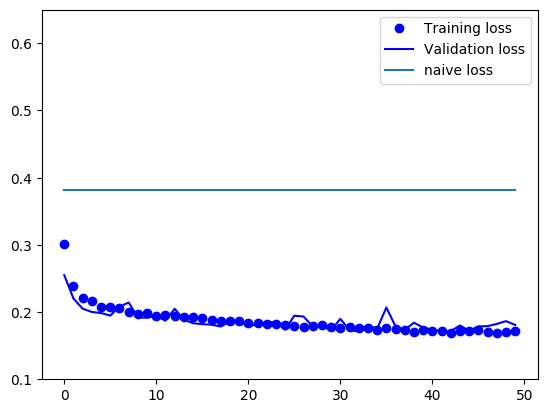

In [0]:
plot_history(loss_simple,val_loss_simple)

Normalement, ça devrait être bien mieux. 

### GRU RNN

Le layer `GRU` (= "gated recurrent unit") a été développé par Cho et al. en 2014. C'est une versoin allégée du LSTM: plus facile à entrainé, mais un peu moins de pouvoir de représentation. 

Cette balance entre le cout de calcul et le pouvoir de représentation est présent partout en machine-learning. 


In [0]:
model_gru = Sequential()
model_gru.add(layers.GRU(32, input_shape=(x_val.shape[1], 13)))
model_simple.add(layers.Dense(20))
model_gru.add(layers.Dense(1))
model_gru.compile(optimizer=RMSprop(), loss='mae')

loss_gru=[]
val_loss_gru=[]

In [0]:
train_model(model_gru,loss_gru,val_loss_gru)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/50
100/100 [==============================] - 7s 70ms/step - loss: 0.3237 - val_loss: 0.2968
Epoch 2/50
100/100 [==============================] - 7s 67ms/step - loss: 0.2651 - val_loss: 0.2659
Epoch 3/50
100/100 [==============================] - 7s 68ms/step - loss: 0.2495 - val_loss: 0.2470
Epoch 4/50
100/100 [==============================] - 7s 67ms/step - loss: 0.2332 - val_loss: 0.2265
Epoch 5/50
100/100 [==============================] - 7s 65ms/step - loss: 0.2257 - val_loss: 0.2077
Epoch 6/50
100/100 [==============================] - 7s 65ms/step - loss: 0.2129 - val_loss: 0.1997
Epoch 7/50
100/100 [==============================] - 7s 65ms/step - loss: 0.2057 - val_loss: 0.1912
Epoch 8/50
100/100 [==============================] - 7s 65ms/step - loss: 0.1930 - val_loss: 0.2046
Epoch 9/50
100/100 [==============================] - 7s 65ms/step - loss: 0.1898 - val_loss: 0.18

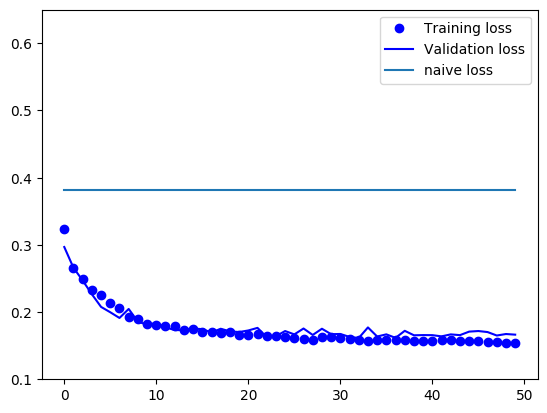

In [0]:
plot_history(loss_gru,val_loss_gru)

### recurrent dropout contre le sur-apprentissage

Si vous êtes allé assez loin dans l'entrainenement vous observerez du sur-apprentissage. 

On va utiliser la technique classique du: dropout, qui consiste à mettre à zéro aléatoirement un certain nombre d'unité (=neurone), en changeant ce masquage à chaque flux de donnée. Cela limite la corrélation entre les neurones et les données. 


In [0]:
model_drop = Sequential()
model_drop.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(x_val.shape[1], 13)
                    ))
model_simple.add(layers.Dense(20))
model_drop.add(layers.Dense(1))

model_drop.compile(optimizer=RMSprop(), loss='mae')
loss_drop=[]
val_loss_drop=[]


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
train_model(model_drop,loss_drop,val_loss_drop)

Epoch 1/50
100/100 [==============================] - 8s 82ms/step - loss: 0.3866 - val_loss: 0.3182
Epoch 2/50
100/100 [==============================] - 7s 73ms/step - loss: 0.3172 - val_loss: 0.2864
Epoch 3/50
100/100 [==============================] - 7s 74ms/step - loss: 0.3038 - val_loss: 0.2847
Epoch 4/50
100/100 [==============================] - 7s 74ms/step - loss: 0.2941 - val_loss: 0.2624
Epoch 5/50
100/100 [==============================] - 7s 74ms/step - loss: 0.2822 - val_loss: 0.2504
Epoch 6/50
100/100 [==============================] - 7s 74ms/step - loss: 0.2794 - val_loss: 0.2460
Epoch 7/50
100/100 [==============================] - 7s 74ms/step - loss: 0.2702 - val_loss: 0.2314
Epoch 8/50
100/100 [==============================] - 7s 75ms/step - loss: 0.2674 - val_loss: 0.2412
Epoch 9/50
100/100 [==============================] - 7s 74ms/step - loss: 0.2639 - val_loss: 0.2261
Epoch 10/50
100/100 [==============================] - 7s 74ms/step - loss: 0.2608 - val_lo

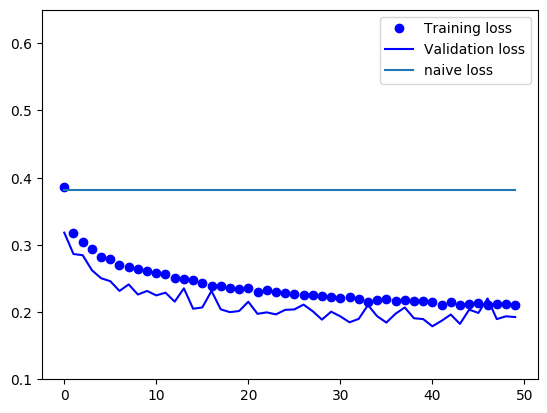

In [0]:
plot_history(loss_drop,val_loss_drop)

Great success; we are no longer overfitting. However, while we have more stable evaluation scores, our best 
scores are not much lower than they were previously.

### Empilons les couches récurentes

On empile deux couches RNN.   La seconde prend en entrée toute la suite des `outputs` de la première.   Ainsi les deux layers RNN travaillent en parallèle le long de la séquence temporelle. 


On obtient un réseau récurrent plus "profond", qui a un meilleur pouvoir de représentation, donc aussi plus de facilités à faire du sur-apprentissage. Le `drop_out` compense cela.  



***A vous:*** Dans le code ci-dessous, où voyez vous que la seconde couche prend en entrée toute la suite des `outputs` de la première?

In [0]:
model_stack = Sequential()
model_stack.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(x_val.shape[1], 13)
                 ))
model_stack.add(layers.GRU(32, activation='relu',  #64
                     dropout=0.1, 
                     recurrent_dropout=0.5))

model_simple.add(layers.Dense(20))


model_stack.add(layers.Dense(1))


model_stack.compile(optimizer=RMSprop(), loss='mae')
loss_stack=[]
val_loss_stack=[]


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
train_model(model_stack,loss_stack,val_loss_stack)

Epoch 1/50
100/100 [==============================] - 14s 139ms/step - loss: 0.2187 - val_loss: 0.1885
Epoch 2/50
100/100 [==============================] - 14s 137ms/step - loss: 0.2221 - val_loss: 0.1939
Epoch 3/50
100/100 [==============================] - 14s 139ms/step - loss: 0.2189 - val_loss: 0.1948
Epoch 4/50
100/100 [==============================] - 14s 139ms/step - loss: 0.2204 - val_loss: 0.1945
Epoch 5/50
100/100 [==============================] - 14s 137ms/step - loss: 0.2179 - val_loss: 0.1879
Epoch 6/50
100/100 [==============================] - 14s 138ms/step - loss: 0.2185 - val_loss: 0.1984
Epoch 7/50
100/100 [==============================] - 14s 140ms/step - loss: 0.2170 - val_loss: 0.1821
Epoch 8/50
100/100 [==============================] - 14s 138ms/step - loss: 0.2161 - val_loss: 0.1942
Epoch 9/50
100/100 [==============================] - 14s 137ms/step - loss: 0.2197 - val_loss: 0.1942
Epoch 10/50
100/100 [==============================] - 14s 137ms/step - l

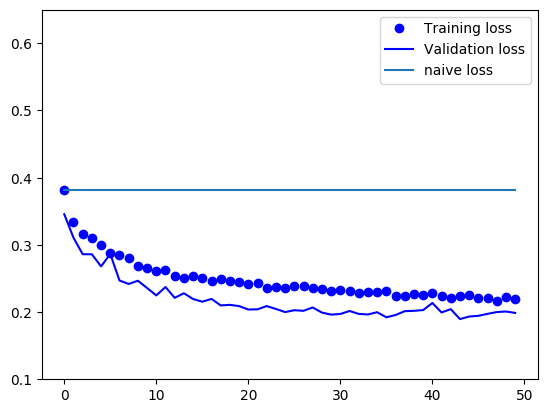

In [0]:
plot_history(loss_stack,val_loss_stack)

## Conclusion

Laissons les derniers mots à François Chollet. 


Il y a de nombreuse choses à tenter pour améliorer notre modèle:

* Ajuster le nombre d'unité (=nb de neurone) dans chacune des couches.
* Ajuster le learning rate
* Tester le LSTM à la place du GRU
* Essayer un réseau dense plus important à la tête du modèle. 
* Et au final, faire tourner le modèle sur le jeu test, pour vérifier que vous n'avez pas fait de sur-apprentissage (à force d'utiliser le jeu de validation). 

De deep learning est plus un art qu'une science. Chaque problème est unique et requiert des stratégies spécifique, que l'on construit empiriquement. Il n'y a pas de théorie qui puisse vous donner les  valeurs optimales des hyper-paramètres. 

### Résumons

Voici ce qu'il y a à retenir: 

* Il faut toujours trouver une 'accuracy triviale' à battre. 
* Commencer par utiliser des modèles simples avant les modèles couteux. Par fois le modèle simple constitue la meilleurs option. 
* Dès que les données dépendent du temps, il faut utiliser des modèles qui prennent en compte cette dépendance ex: RNN ou CNN 1 dimensionnel. 
* Il faut utiliser `dropout` et `recurrent_dropout` dans les RNN.
* Les RNN empilés ont un meilleurs pouvoir de représentation des données. Ils offres des avantages dans les problèmes complexes (ex: traduction), mais peuvent être inutile pour des problèmes simples. 
* Pendez à utiliser des RNN bidirectionnels, notamment pour les données textuelles. Cependant, ils sont peu efficace quand c'est surtout le passé proche qui influe sur le présent. 

* Certains concepts n'ont pas été abordé dans ce TP, notamment l'"attention", très utilie pour les données textuelles.  
